# Factor Analysis via MCMC sampling

In the previous notebook about factor analysis via the R "psych" package we've used an opaque pre-packaged algorithm, where we cannot tell very well what it does internally. In addition, we cannot modify and adapt it or use it as a sub-model in a larger model. Therefore let's see how we can replicate the above result by using an MCMC Stan implementation of the factor analysis model.

This example is based on [Fitting a Bayesian Factor Analysis Model in Stan](https://rfarouni.github.io/assets/projects/BayesianFactorAnalysis/BayesianFactorAnalysis.html) by [Rick Farouni](http://rfarouni.github.io).

The biggest obstacle to overcome when using MCMC Stan models in general is to make the models **identifiable**. 

We say that a model is not identified if there are two or more distinct parameter points that can generate the same joint probability distribution. Rick Farouni does a very good job in his blog post above to explain the symmetries that you need to consider in order to make the factor analysis model identifiable.

If a model is not identifiable then the MCMC chain will jump between the symmetrically identical parameter configurations (e.g. "label switching" or "aliasing") and your output will be "crap".

## Standard python imports

In [1]:
%%capture
%matplotlib inline
import locale
locale.setlocale(locale.LC_ALL, 'C')
import os, timeit, collections

import IPython.display

import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.linalg, pandas as pd, \
    matplotlib.pyplot as plt, matplotlib.dates, xarray as xr, seaborn as sns
    
import readline # https://github.com/ContinuumIO/anaconda-issues/issues/152
%load_ext rpy2.ipython
import rpy2, rpy2.rinterface, rpy2.robjects, rpy2.robjects.packages, rpy2.robjects.lib, rpy2.robjects.lib.grid, \
    rpy2.robjects.lib.ggplot2, rpy2.robjects.pandas2ri, rpy2.interactive.process_revents, \
    rpy2.interactive, rpy2.robjects.lib.grdevices
# rpy2.interactive.process_revents.start()
rpy2.robjects.pandas2ri.activate()

import pymc3 as pm
from theano import tensor as tt
import pystan, pystan.external.pymc.plots

import datetime, time, pytz, dateutil.relativedelta

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(suppress=True)
np.set_printoptions(precision=8)
np.core.arrayprint._line_width = 180

sns.set()

SEED = 42
np.random.seed(SEED)

In [2]:
import fa_basics

## Sample data generation

In [3]:
X, L,_ = fa_basics.build_toy_dataset()

df = pd.DataFrame(X.T, columns=['x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x07', 'x08', 'x09', 'x10'])
df.head()

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10
0,0.5789,-0.7172,1.4849,0.4836,0.1614,0.6961,1.0573,0.3687,1.2239,0.5746
1,1.4643,0.0542,0.1990,-0.1562,1.3499,-0.4860,0.6667,-0.3078,0.7026,0.0125
2,2.1083,0.4471,0.1619,-0.7498,0.6475,0.7095,0.6008,1.0736,-0.9696,-0.5367
3,0.7378,-0.8622,-0.5964,-0.7825,1.5627,-0.4754,0.2287,-0.5552,-1.3761,-0.9860
4,1.0815,-2.3869,-1.7890,-2.6238,0.7170,-2.2701,-1.4723,-1.2803,-0.8575,-0.4681


## Stan model

### Defining the model

Let's start with the definition of the model in the Stan modeling language:

In the data block we define the input variables to the model:

In [4]:
model_string_data = """
data {
  int<lower=1> N;                // Number of samples 
  int<lower=1> D;                // The original dimension; convert Ps to Ds
  int<lower=1> K;                // The latent dimension; convert Ds to Ks
  matrix[N,D] X;                 // The data matrix data matrix of order [N,D]
}
"""

In the transformed data block we define static parameters that are derived from the input parameters:

In [5]:
model_string_transformed_data = """
transformed data {
  int<lower=1> M;
  vector[D] mu;
  M  = K*(D-K)+ K*(K-1)/2;  // number of non-zero loadings
  mu = rep_vector(0.0,D);
}
"""

In the parameters block we define the latent variables that we want to infer from the model:

In [6]:
model_string_parameters = """
parameters {    
  vector[M]          L_t;   // lower diagonal elements of L
  vector<lower=0>[K] L_d;   // Diagonal elements of L
  vector<lower=0>[D] psi;   // vector of variances
  real<lower=0>      mu_psi;
  real<lower=0>      sigma_psi;
  real               mu_lt;
  real<lower=0>      sigma_lt;
}
"""

As mentioned above already, one of the problems will be to deal with the symmetries and aliasing in this model. As described in chapter 12.1.3 "Unidentifiability" of [Machine Learning: A Probabilistic Perspective](https://www.amazon.com/Machine-Learning-Probabilistic-Perspective-Computation/dp/0262018020) one way to ensure identifiability is to force $L$ to be lower triangular.

For that we define in the parameters block the parameters $L_t$ to be the lower diagonal elements of L and $L_d$ to be the diagonal elements of $L$.

In the transformed parameters block we define parameters that are recalculated in every iteration of the MCMC algorithm:

In [7]:
model_string_transformed_parameters = """
transformed parameters{
    cholesky_factor_cov[D,K] L;  //lower triangular factor loadings Matrix 
    cov_matrix[D]            Q;  //Covariance mat
    {
      int idx1 = 0;
      int idx2 = 0;
      real zero = 0.0;
   
      for(i in 1:D){
        for(j in (i+1):K){
          idx1 = idx1 + 1;
          L[i,j] = zero; //constrain the upper triangular elements to zero 
        }
      }
      for (j in 1:K) {
        L[j,j] = L_d[j];
        for (i in (j+1):D) {
          idx2 = idx2 + 1;
          L[i,j] = L_t[idx2];
        } 
      }
    } 
    Q = L*L'+diag_matrix(psi); 
}
"""

I'll explain a few of the consructs above, but for more details have a look at the [Modeling Language User's Guide and Reference Manual, Version 2.16.0 ](https://github.com/stan-dev/stan/releases/download/v2.16.0/stan-reference-2.16.0.pdf) of Stan. This is really very well written and very readable!

On page 34 they explain that `cholesky_factor_cov` defines a constrained data type:
> The type cholesky_factor_cov is for Cholesky factors of covariance matrices (lower triangular, positive diagonal, product with own transpose is a covariance matrix).

In the same way `cov_matrix` is a constrained data type:
> There are specialized matrix data types ... cov_matrix for ... covariance matrices (symmetric, positive definite). $\newcommand{bfvec}[1]{{\bf #1}}$

In the rest of the code block we transfer the values from $L_t$ and $L_d$ to the $L$ matrix plus set the upper triangular values to 0. Finally we calculate $\bfvec{Q}=\hbox{cov}[x]=\bfvec{L}\bfvec{L}^T+\bfvec{\Psi}$ (see equation 12.5 in [Machine Learning: A Probabilistic Perspective](https://www.amazon.com/Machine-Learning-Probabilistic-Perspective-Computation/dp/0262018020)). $\bfvec{Q}$ does not suffer from the identifiability problem, because it is defined in respect to the observable values in $\bfvec{X}$.

Last but not least we define the actual model:

In [8]:
model_string_model = """
model {
    // the hyperpriors 
    mu_psi ~ cauchy(0, 1);
    sigma_psi ~ cauchy(0,1);
    mu_lt ~ cauchy(0, 1);
    sigma_lt ~ cauchy(0,1);
    // the priors 
    L_d ~ cauchy(0,3);
    L_t ~ cauchy(mu_lt,sigma_lt);
    psi ~ cauchy(mu_psi,sigma_psi);
    //The likelihood
    for( j in 1:N)
        X[j] ~ multi_normal(mu,Q); 
    }
"""
model_string = model_string_data + model_string_transformed_data + model_string_parameters + \
    model_string_transformed_parameters + model_string_model

The above is quite straight forward. 

The diagonal elements of $\bfvec{\Psi}$ plus their priors $\mu_\Psi, \sigma_\Psi$ are drawn from a [cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution), which has fat tails, to make large values possible. The fact that the diagonal elements of $\bfvec{\Psi}$ have to be positive is taken care of by the variable declaration `vector<lower=0>[D] psi;` with a lower bound of 0.

The same "recipe" is used for drawing parameters for $L_d$ and $L_t$.

Finally we sample each row of $\bfvec{X}$ (e.g. each observation) from a `multi_normal` using the covariance matrix $\bfvec{Q}$.

### Compiling the model

As a next step we compile the model. This will take some time. The `capture` magic below is used to suppress the warnings that the compilation process is spitting out. To nevertheless get an idea of how much time the compilation takes we capture that time in the variable `t` and print it below.

In [9]:
%%capture --no-display
sm = None
def compile_stand_model():
    global sm
    sm = pystan.StanModel(model_code=model_string)

t = timeit.Timer(lambda : compile_stand_model()).timeit(number=1) 

In [10]:
print('Time needed for compiling the stan model: {} seconds'.format(t))

Time needed for compiling the stan model: 44.68294403599975 seconds


### Fitting the model

Let's have a look at the data we have:

In [11]:
X.shape

(10, 300)

In [12]:
N = X.shape[1]
D = L.shape[0]
K = L.shape[1]
(N, D, K)

(300, 10, 3)

This means that we have 300 samples, where each sample is of dimension 10 and we believe that the relevant sub-space is of dimension 3. We take this result from the previous notebook and its `scree plot`.

Next we prepare the input data structures that we have to hand-over to the Stan MCMC sampling method. The `initfun` is used to give the chains good starting values. We will sample 4 MCMC chains and sample 300 values from each chain. Stan will by default use the first 150 values as warmup and throw them away, which will finally leave us with $4\times(300-150)=600$ samples for each value.

In [13]:
data_list = dict(N = N, D = D, K = K, X = X.T) # take values from above without regenerating
M = int(K*(D-K)+ K*(K-1)/2)

def initfun():
    return dict(L_t       = np.zeros(M) + stats.uniform.rvs(loc=-0.1,scale=+0.1),
                L_d       = np.full(K, 0.5) + stats.uniform.rvs(loc=-0.1,scale=+0.1),
                psi       = np.full(D, 0.2) + stats.uniform.rvs(loc=-0.1,scale=+0.1),
                sigma_psi = 0.15 + stats.uniform.rvs(loc=-0.1,scale=+0.1),
                mu_psi    = 0.2  + stats.uniform.rvs(loc=-0.1,scale=+0.1),
                sigma_lt  = 0.5  + stats.uniform.rvs(loc=-0.1,scale=+0.1),
                mu_lt     = 0.0  + stats.uniform.rvs(loc=-0.1,scale=+0.1))

# initfun()
Nchains = 4
Niter   = 300

We call the sampling method with our data structures from above. We are using the `NUTS` MCMC algorithm, which is also Stan's default, e.g. we could have left this parameter undefined. In the `pars` input we specify which samples the system should keep. Otherwise it would have alos kept many other values (e.g. the $\bfvec{Q}$ values and the like) we're not interested in.

In [14]:
%%time
fit = sm.sampling(data=data_list, iter=Niter, chains=Nchains, thin=1, seed=SEED, init=initfun, 
                  algorithm='NUTS', pars=["L","psi","sigma_psi","mu_psi","sigma_lt","mu_lt"]) # warmup=100,

CPU times: user 36 ms, sys: 100 ms, total: 136 ms
Wall time: 17 s


Finally we print the fit values:

In [15]:
print(fit)

Inference for Stan model: anon_model_6dd2b19abd43b3100c775eb367c52538.
4 chains, each with iter=300; warmup=150; thin=1; 
post-warmup draws per chain=150, total post-warmup draws=600.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L[0,0]      0.91  2.4e-3   0.05   0.81   0.88   0.91   0.95   1.03    487    1.0
L[1,0]      0.05  2.5e-3   0.06  -0.08 7.2e-3   0.05   0.09   0.17    600   1.01
L[2,0]      0.19  2.8e-3   0.06   0.09   0.15    0.2   0.23   0.31    387    1.0
L[3,0]     -0.05  2.9e-3   0.06  -0.17  -0.09  -0.05-7.3e-3   0.07    443    1.0
L[4,0]      0.69  2.1e-3   0.05    0.6   0.66   0.69   0.73   0.79    600    1.0
L[5,0]     -0.05  3.0e-3   0.06  -0.17  -0.09  -0.05  -0.01   0.06    388   1.01
L[6,0]      0.45  3.1e-3   0.06   0.33   0.41   0.45   0.49   0.56    355   1.01
L[7,0]   -6.0e-3  2.3e-3   0.06  -0.12  -0.05-8.4e-3   0.04    0.1    600    1.0
L[8,0]      -0.1  3.2e-3   0.07  -0.21  -0.14   -0.1  -0.05   0.03    434    1.0
L[9,0

### Validating the fit via some traceplots

And we also plot a view traceplots just to verify that the sampling process actually converged.

In [16]:
#surrogate_trace = {
#    'L[0,0]'  : fit.extract(permuted=True, pars=['L','psi', 'mu_lt'])['L'][:,0,0],
#    'L[9,2]' : fit.extract(permuted=True, pars=['L','psi', 'mu_lt'])['L'][:,9,2],
#    'psi[7]'  : fit.extract(permuted=True, pars=['L','psi', 'mu_lt'])['psi'][:,7],
#    'mu_lt'   : fit.extract(permuted=True, pars=['L','psi', 'mu_lt'])['mu_lt'],
#}
#pystan.external.pymc.plots.traceplot(surrogate_trace,vars=['L[0,0]', 'L[9,2]', 'psi[7]', 'mu_lt'])

In [17]:
fit_extracted = fit.extract(permuted=False)
surrogate_trace = collections.OrderedDict(
    [(fname, fit_extracted[:,:,i]) for i, fname in enumerate(fit.sim['fnames_oi'])])

# For whatever reason the following function is doubling the output:
# pystan.external.pymc.plots.traceplot(surrogate_trace,vars=['L[0,0]', 'L[9,2]', 'psi[7]', 'mu_lt'])

/home/user/cs/local/install/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  if __name__ == '__main__':


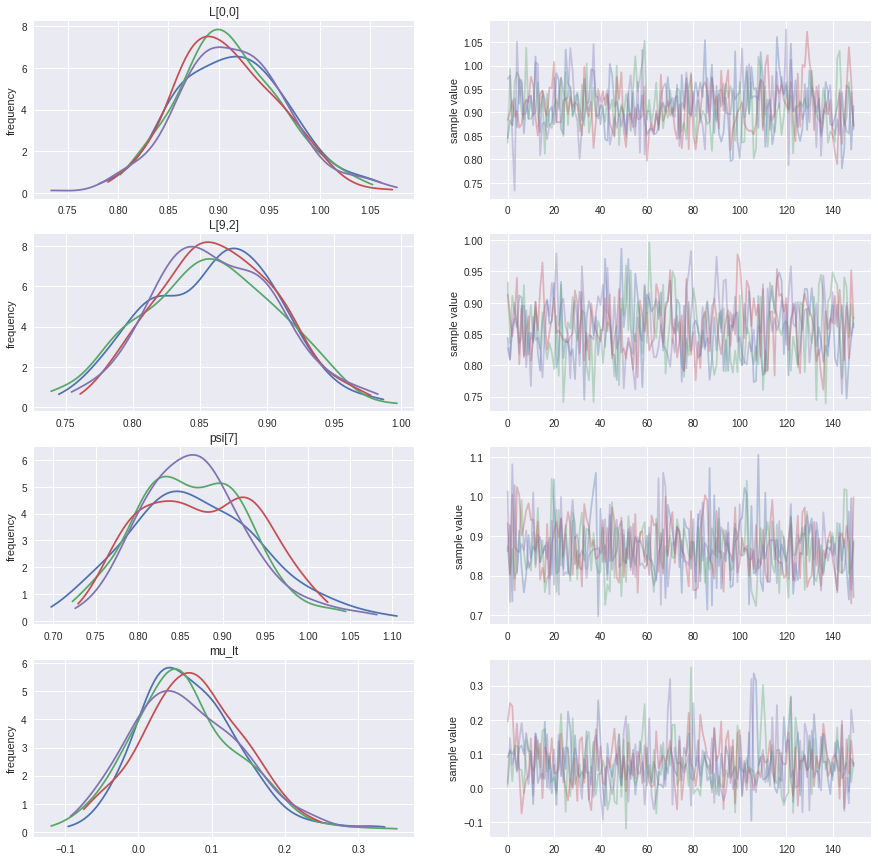

In [18]:
from scipy.stats import kde
def kdeplot_op(ax, data):
    data = np.atleast_2d(data.T).T
    for i in range(data.shape[1]):
        d = data[:, i]
        density = kde.gaussian_kde(d)
        l = np.min(d)
        u = np.max(d)
        x = np.linspace(0, 1, 100) * (u - l) + l

        ax.plot(x, density(x))

vars=['L[0,0]', 'L[9,2]', 'psi[7]', 'mu_lt']
n = len(vars)
f, ax = plt.subplots(n, 2, squeeze=False, figsize=(15,15))
#fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

for i, v in enumerate(vars):
    d = np.squeeze(surrogate_trace[v])

    if surrogate_trace[v].dtype.kind == 'i':
        ax[i, 0].hist(d, bins=sqrt(d.size))
    else:
        kdeplot_op(ax[i, 0], d)
    ax[i, 0].set_title(str(v))
    ax[i, 1].plot(d, alpha=.35)

    ax[i, 0].set_ylabel("frequency")
    ax[i, 1].set_ylabel("sample value")


### Extracting $\bfvec{L}$ and $\bfvec{\Psi}$

In order to extract the values we create a dataframe where the index is the name of the variable and the only data column contains the mean values:

In [19]:
surrogate_trace_means = [(key, np.mean(vals)) for key, vals in surrogate_trace.items()]
surrogate_trace_df = pd.DataFrame(surrogate_trace_means, columns=['name', 'value'])
surrogate_trace_df.set_index('name',inplace=True)
surrogate_trace_df.head()

,value
name,
"L[0,0]",0.9123
"L[1,0]",0.0475
"L[2,0]",0.1942
"L[3,0]",-0.0507
"L[4,0]",0.6915


From there we can extract the values via the following function:

In [20]:
def extract(mean_values_series, startswith=None, shape=None):
    values = [(mean_values_series.index[i], mean_values_series[i]) for i in range(len(mean_values_series)) if mean_values_series.index[i].startswith(startswith)]
    values_df = pd.DataFrame(values)
    if len(shape) == 1:
        return values_df.values[:,1].astype(np.float64)
    elif len(shape) == 2:
        if shape[0]*shape[1] != len(values_df):
            print('the shape to extract {} does not fit the size of values available {}'.format(shape, len(values_df)))
            return None
        return np.reshape(values_df.values[:,1],shape,order='F').astype(np.float64)

#### Comparing the $\bfvec{\Psi}$

Here are the values in sorted order from our fitted model:

In [21]:
psis = extract(surrogate_trace_df['value'], startswith='psi', shape=[L.shape[0]])
np.sort(psis)

array([ 0.15008384,  0.16186503,  0.17859575,  0.20264606,  0.20854494,  0.21730889,  0.23689202,  0.28447394,  0.40563518,  0.86905808])

And here are the values of our data generation process in sorted order:

In [22]:
original_psi = np.array([0.2079, 0.19, 0.1525, 0.20, 0.36, 0.1875, 0.1875, 1.00, 0.27, 0.27])
np.sort(original_psi)

array([ 0.1525,  0.1875,  0.1875,  0.19  ,  0.2   ,  0.2079,  0.27  ,  0.27  ,  0.36  ,  1.    ])

The values are not too far away from the real values.

#### Comparing the $\bfvec{L}$

We extract our $\bfvec{L}$ values from our fitted model into the `loadings` variable.

In [23]:
loadings = extract(surrogate_trace_df['value'], startswith='L', shape=L.shape)
loadings

array([[ 0.91226969,  0.        ,  0.        ],
       [ 0.04750325,  0.90625441,  0.        ],
       [ 0.19416275,  0.16745181,  0.87665593],
       [-0.05072614,  0.40926312,  0.83521392],
       [ 0.69145075,  0.02603464, -0.00225553],
       [-0.05008456,  0.4671189 ,  0.77629208],
       [ 0.44783256, -0.01814877,  0.80263857],
       [-0.00595927,  0.03445308, -0.05030833],
       [-0.0970766 , -0.35084779,  0.8797037 ],
       [-0.0457182 , -0.29402641,  0.86079622]])

And we use again like in the previous notebook the principal angles:

In [24]:
180.0*fa_basics.calc_principal_angles(L, loadings)/np.pi

array([ 1.71831918,  3.41126643,  4.33808346])

Or the Grassmanian norm:

In [25]:
180.0*fa_basics.grassmannian_norm(L, loadings)/np.pi

4.3339399084064594

To compare the quality of the fit. The fit is basically equivalent to what we've got from the R 'psych' package.

## What does more data help to improve the fit?

Let's try and see how much the fit becomes better if we have more data at our hands. We generate a factor of 3 more data. The time needed to fit the model increases rapidly with the amount of data you supply.

In [26]:
X, L,_ = fa_basics.build_toy_dataset(N=3*300)

df = pd.DataFrame(X.T, columns=['x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x07', 'x08', 'x09', 'x10'])
df.head()

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10
0,-0.7055,0.7544,0.0292,0.7401,-1.9285,0.9545,0.3676,0.9690,-0.3193,0.1975
1,0.5881,-0.5624,-1.3809,-0.1652,1.6575,-1.4209,-0.5899,-0.0013,-0.1818,-0.4775
2,-0.0092,1.1389,-0.5017,-0.5490,-0.1786,-0.1365,-1.0448,-1.0902,-0.9934,-0.4197
3,-2.7059,0.0688,-0.0560,0.0700,-2.2742,0.0580,-0.6326,-0.2760,0.8119,0.3929
4,-0.7196,1.0504,-1.1895,0.3200,-1.4929,-0.2028,-0.8141,0.5971,-1.2519,-1.7286


In [27]:
X.shape

(10, 900)

In [28]:
N = X.shape[1]
D = L.shape[0]
K = L.shape[1]
(N, D, K)

(900, 10, 3)

I also tried to see how much the number of iterations improves the result, but it does not improve a lot. The time increases more or less proportional to the number of iterations, e.g. this has little return on time invested.

In [29]:
data_list = dict(N = N, D = D, K = K, X = X.T) # take values from above without regenerating
M = int(K*(D-K)+ K*(K-1)/2)
Nchains = 6
Niter   = 300

In [30]:
%%time
fit = sm.sampling(data=data_list, iter=Niter, chains=Nchains, thin=1, seed=SEED, init=initfun, 
                  algorithm='NUTS', pars=["L","psi","sigma_psi","mu_psi","sigma_lt","mu_lt"]) # warmup=100,

CPU times: user 60 ms, sys: 96 ms, total: 156 ms
Wall time: 58.1 s


In [31]:
print(fit)

Inference for Stan model: anon_model_6dd2b19abd43b3100c775eb367c52538.
6 chains, each with iter=300; warmup=150; thin=1; 
post-warmup draws per chain=150, total post-warmup draws=900.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L[0,0]      1.01  9.9e-4   0.03   0.95   0.99   1.01   1.03   1.07    900    1.0
L[1,0]     -0.04  1.1e-3   0.03  -0.11  -0.06  -0.04  -0.02   0.03    900    1.0
L[2,0]      0.28  1.5e-3   0.03   0.21   0.25   0.28    0.3   0.34    559    1.0
L[3,0]   -3.9e-3  1.5e-3   0.04  -0.08  -0.03-2.7e-3   0.02   0.06    597   1.01
L[4,0]      0.78  9.8e-4   0.03   0.72   0.76   0.78   0.79   0.84    900    1.0
L[5,0]     -0.01  1.5e-3   0.04  -0.08  -0.04  -0.01   0.01   0.06    582   1.01
L[6,0]      0.51  1.3e-3   0.03   0.45   0.49   0.51   0.54   0.58    662    1.0
L[7,0]     -0.06  1.1e-3   0.03  -0.13  -0.08  -0.06  -0.04   0.01    900    1.0
L[8,0]      0.06  1.2e-3   0.03-7.6e-3   0.03   0.06   0.08   0.12    802    1.0
L[9,0

In [32]:
fit_extracted = fit.extract(permuted=False)
surrogate_trace = collections.OrderedDict(
    [(fname, fit_extracted[:,:,i]) for i, fname in enumerate(fit.sim['fnames_oi'])])

surrogate_trace_means = [(key, np.mean(vals)) for key, vals in surrogate_trace.items()]
surrogate_trace_df = pd.DataFrame(surrogate_trace_means, columns=['name', 'value'])
surrogate_trace_df.set_index('name',inplace=True)
surrogate_trace_df.head()

loadings = extract(surrogate_trace_df['value'], startswith='L', shape=L.shape)

180.0*fa_basics.calc_principal_angles(L, loadings)/np.pi

/home/user/cs/local/install/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  if __name__ == '__main__':


array([ 0.81093094,  2.37230036,  3.33735047])

## How does ADVI do on this model?

In [34]:
%%time
fit = sm.vb(data=data_list, algorithm='meanfield', output_samples=10000)

CPU times: user 7.07 s, sys: 56 ms, total: 7.12 s
Wall time: 7.09 s


In [35]:
advi_samples_df = pd.read_csv(fit['args']['sample_file'].decode('ascii'), comment='#')
advi_samples_df.head()
advi_trade_series = advi_samples_df.mean(axis=0)
advi_trade_series.head()
loadings = extract(advi_trade_series, startswith='L.', shape=L.shape)

180.0*fa_basics.calc_principal_angles(L, loadings)/np.pi

array([ 0.67140865,  2.22449008,  4.88704707])

### And with considerably more data?

In [39]:
X, L,_ = fa_basics.build_toy_dataset(N=100*300)
df = pd.DataFrame(X.T, columns=['x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x07', 'x08', 'x09', 'x10'])
N = X.shape[1]
D = L.shape[0]
K = L.shape[1]
data_list = dict(N = N, D = D, K = K, X = X.T) # take values from above without regenerating

In [40]:
%%time
fit = sm.vb(data=data_list, algorithm='meanfield', output_samples=10000)

CPU times: user 1min 55s, sys: 460 ms, total: 1min 55s
Wall time: 1min 55s


In [41]:
advi_samples_df = pd.read_csv(fit['args']['sample_file'].decode('ascii'), comment='#')
advi_samples_df.head()
advi_trade_series = advi_samples_df.mean(axis=0)
advi_trade_series.head()
loadings = extract(advi_trade_series, startswith='L.', shape=L.shape)

180.0*fa_basics.calc_principal_angles(L, loadings)/np.pi

array([  2.05110127,   4.20773536,  47.06254848])

ADVI is able to get back with results, but how would you know if you can trust the result given this high value of deviation from the original matrix $\bfvec{L}$ as shown by the principal angles?